In [1]:
import matplotlib.pyplot as plt

from fitting_uncertainty import create_ensemble, load_data, create_datasets
import torch

tkwargs = {"dtype": torch.float}
scales = [0.95, 0.975,1.0,1.025, 1.05]

emittances = []
betas = []
alphas = []

for scale in scales:
    semits = []
    sbetas = []
    salphas = []
    for ensemble_index in [0,1,2,3,4]:
        #print(scale)
        tkwargs = {"dtype": torch.float}
        save_dir = f"uncertainty/ensemble_mse_scale_{scale}"
        quad_strengths, image_data, bins, xx = load_data(tkwargs)
        train_dset = torch.load(save_dir + "/train.dset")
        test_dset = torch.load(save_dir + "/test.dset")

        bin_width = bins[1] - bins[0]
        bandwidth = bin_width / 2
        ensemble = create_ensemble(bins, bandwidth)

        from torchensemble.utils import io
        io.load(ensemble, save_dir)

        n_particles = 100000
        #ensemble_index = -1
        ensemble[ensemble_index].beam.set_base_beam(
            ensemble[ensemble_index].beam.base_dist,
            n_particles,
            p0c=torch.tensor(63.0e6)
        )

        ensemble.cuda();

        initial_beam = ensemble[ensemble_index].beam()

        # propagate particles w/quad off
        initial_y = initial_beam.y.cpu().detach().numpy()*1e3
        initial_py = initial_beam.py.cpu().detach().numpy()*1e3

        # distances
        dist_to_slits = 3.38 - 2.84 + 0.12/2.0
        dist_to_screen = 3.38 + 0.12/2.0

        # particles
        slits_y = initial_y + initial_py * dist_to_slits
        slits_py = initial_py

        screen_y = initial_y + initial_py * dist_to_screen
        screen_py = initial_py

        cov = torch.cov(initial_beam.data.T)
        ycov = cov[2:4,2:4]

        emit = torch.det(ycov).sqrt()
        twiss = ycov / emit
        #print(f"beta {twiss[0,0]}")
        #print(f"alpha {-twiss[1,0]}")
        #print(f"gamma {twiss[1,1]}")

        # geometric emittance
        #print(f"geo_emit: {emit}")
        #print(f"norm emit: {emit*63.0/0.511}")
        
        semits.append(emit*63.0/0.511)
        sbetas.append(twiss[0,0])
        salphas.append(-twiss[1,0])
    emittances.append(semits)
    betas.append(sbetas)
    alphas.append(salphas)

emittances = torch.tensor(emittances)
betas = torch.tensor(betas)
alphas = torch.tensor(alphas)

C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
# entire stats
# calculate propability of each scale if the rms error is 5%
dist = torch.distributions.Normal(1.0,0.05)
vals = torch.tensor(scales)
probs = dist.log_prob(vals).exp().unsqueeze(0).repeat(5, 1).T

def get_weighted_stats(vals):
    prob_weighted_vals = vals * probs
    weighted_val_mean = prob_weighted_vals.sum() / probs.sum()
    weighted_val_variance = (probs * (emittances - weighted_val_mean)**2).sum() / probs.sum() 
    return weighted_val_mean, weighted_val_variance
    


for name, ele in zip(["emit","beta","alpha"],[emittances, betas, alphas]):
    mean, variance = get_weighted_stats(ele)
    print(f"mean {name}: {ele.mean()} +/- {ele.std()}")


mean emit: 4.688577973865904e-06 +/- 2.8994477929700224e-07
mean beta: 8.913043975830078 +/- 0.7495744824409485
mean alpha: -0.0379997193813324 +/- 0.1111699789762497


In [7]:
for i in range(5):
    # ensemble rms
    for name, ele in zip(["emit","beta","alpha"],[emittances[i], betas[i], alphas[i]]):
        ele = torch.tensor(ele)
        print(f"{i} {name}: {ele.mean()} +/- {ele.std()}")


0 emit: 4.6199284042813815e-06 +/- 1.9093047143314834e-08
0 beta: 9.585647583007812 +/- 0.06852658092975616
0 alpha: 0.07130633294582367 +/- 0.0029983045533299446
1 emit: 5.1141446419933345e-06 +/- 1.8462825934761895e-08
1 beta: 9.093748092651367 +/- 0.029050571843981743
1 alpha: 0.09131678938865662 +/- 0.004255979787558317
2 emit: 4.695415555033833e-06 +/- 1.2457899600804012e-08
2 beta: 8.395454406738281 +/- 0.027083657681941986
2 alpha: -0.07173316180706024 +/- 0.0028897677548229694
3 emit: 4.232631908962503e-06 +/- 1.7440795474499282e-08
3 beta: 9.715083122253418 +/- 0.025582248345017433
3 alpha: -0.07533727586269379 +/- 0.0025849626399576664
4 emit: 4.780771632795222e-06 +/- 2.0663643240936835e-08
4 beta: 7.7752885818481445 +/- 0.029366817325353622
4 alpha: -0.20555129647254944 +/- 0.003908201120793819


C:\Users\Ryan Roussel\AppData\Local\Temp\ipykernel_40468\2677380202.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ele = torch.tensor(ele)


In [4]:
import torch
eny = [4.7797, 5.0640, 5.258, 4.7572, 5.0252, 5.2580, 4.9472, 5.1097, 5.4322] # mm mrad 
betay = [8.201, 8.630, 9.083, 8.218, 8.644, 9.083, 7.947, 8.517, 8.775] # m
alphay = [0.097, 0.240, 0.406, 0.101, 0.248, 0.406, 0.085, 0.234, 0.385] # rad
print(f"{torch.tensor(eny).mean()} +/- {torch.tensor(eny).std()}")
print(f"{torch.tensor(betay).mean()} +/- {torch.tensor(betay).std()}")
print(f"{torch.tensor(alphay).mean()} +/- {torch.tensor(alphay).std()}")


5.070133209228516 +/- 0.224358469247818
8.566444396972656 +/- 0.3918430805206299
0.2446666806936264 +/- 0.13221006095409393


## Distribution analysis

In [5]:
import numpy as np
tkwargs = {"dtype": torch.float}
scales = [0.95, 0.975,1.0,1.025, 1.05]

fpath = ""

meas_y = np.load(fpath + "y_recon.npy")*1e3
meas_yp = np.load(fpath + "yp_recon.npy")*1e3

#fig.set_size_inches(10,10)
# create a mesh
x1 = np.linspace(-1.75,1.75,150)
x2 = np.linspace(-0.35,0.35,150)

h_slitscan, xe, ye = np.histogram2d(meas_y, meas_yp, bins=[x1,x2], density=True)

x1c = (xe[:-1] + xe[1:]) / 2
x2c = (ye[:-1] + ye[1:]) / 2

X, Y = np.meshgrid(xe,ye)
Xc, Yc = np.meshgrid(x1c,x2c)

images = []

for scale in scales:
    for ensemble_index in [0,1,2,3,4]:
        #print(scale)
        tkwargs = {"dtype": torch.float}
        save_dir = f"uncertainty/ensemble_mse_scale_{scale}"
        quad_strengths, image_data, bins, xx = load_data(tkwargs)
        train_dset = torch.load(save_dir + "/train.dset")
        test_dset = torch.load(save_dir + "/test.dset")

        bin_width = bins[1] - bins[0]
        bandwidth = bin_width / 2
        ensemble = create_ensemble(bins, bandwidth)

        from torchensemble.utils import io
        io.load(ensemble, save_dir)

        n_particles = 100000
        #ensemble_index = -1
        ensemble[ensemble_index].beam.set_base_beam(
            ensemble[ensemble_index].beam.base_dist,
            n_particles,
            p0c=torch.tensor(63.0e6)
        )

        ensemble.cuda();

        initial_beam = ensemble[ensemble_index].beam()

        # propagate particles w/quad off
        initial_y = initial_beam.y.cpu().detach().numpy()*1e3
        initial_py = initial_beam.py.cpu().detach().numpy()*1e3

        # distances
        dist_to_slits = 3.38 - 2.84 + 0.12/2.0
        dist_to_screen = 3.38 + 0.12/2.0

        # particles
        slits_y = initial_y + initial_py * dist_to_slits
        slits_py = initial_py

        screen_y = initial_y + initial_py * dist_to_screen
        screen_py = initial_py

        h_reconstruction, xe, ye = np.histogram2d(slits_y, slits_py, bins=[x1,x2], density=True)
        images.append(h_reconstruction)

images = np.stack(images)

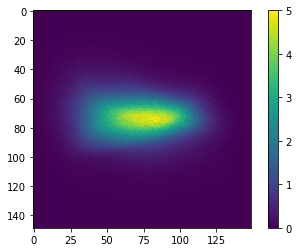

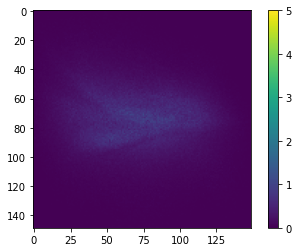

In [9]:
mean_images = images.mean(axis=0)
std_images = images.std(axis=0)


plt.imshow(mean_images.T,vmax=5)
plt.colorbar()
plt.figure()
plt.imshow(std_images.T,vmax=5)
plt.colorbar()